## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=1
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.measure import compare_psnr
import tensorflow as tf
from data.dataset import Dataset
import data.data_selector as ds
import utils.data_processing as dp
import utils.plot_functions as pf
import analysis.analysis_picker as ap

In [3]:
class params(object):
  def __init__(self):
    self.model_type = "lca"
    self.model_name = "lca_768_mnist"
    self.version = "0.0"
    self.save_info = "analysis_kurakin"
    self.overwrite_analysis_log = False

# Computed params
analysis_params = params()
analysis_params.project_dir = (os.path.expanduser("~")+"/Work/Projects/")
analysis_params.model_dir = (analysis_params.project_dir+analysis_params.model_name)

In [4]:
analyzer = ap.get_analyzer(analysis_params.model_type)
analyzer.setup(analysis_params)
analyzer.load_analysis(save_info=analysis_params.save_info)

AttributeError: 'LcaAnalyzer' object has no attribute 'full_image'

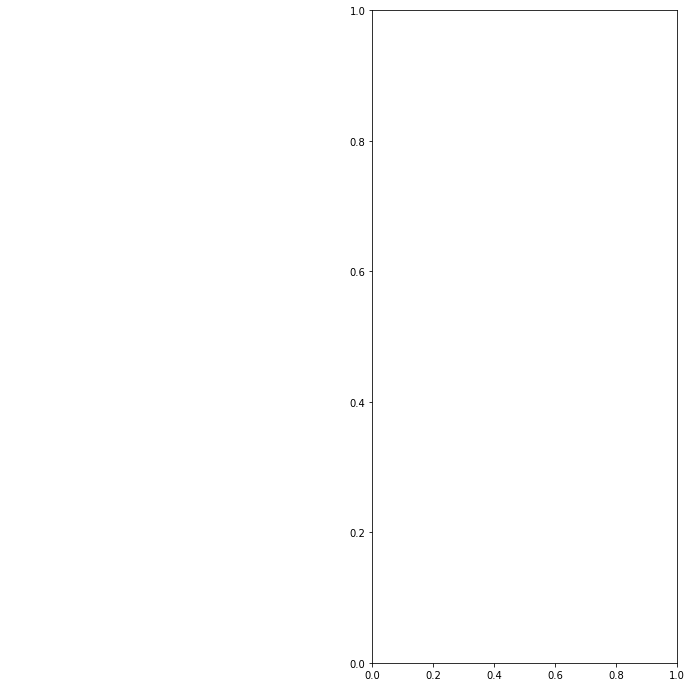

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0] = pf.clear_axis(ax[0])
ax[0].imshow(np.squeeze(analyzer.full_image), cmap="Greys_r")
ax[0].set_title("Input Image\n")
ax[1] = pf.clear_axis(ax[1])
ax[1].imshow(np.squeeze(analyzer.full_recon), cmap="Greys_r")
percent_active = "{:.2f}".format(analyzer.recon_frac_act*100)
psnr = "{:.2f}".format(compare_psnr(analyzer.full_image, analyzer.full_recon.astype(np.float32)))
ax[1].set_title("Reconstruction\n"+percent_active+" percent active")#\n"+"PSNR = "+psnr)
plt.show()
fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params.model_name+"_image_recon.png", transparent=True,
  bbox_inches="tight")


In [ ]:
if not os.path.exists(analyzer.analysis_out_dir+"/vis/adversarial_recons/"):
  os.makedirs(analyzer.analysis_out_dir+"/vis/adversarial_recons/")
if not os.path.exists(analyzer.analysis_out_dir+"/vis/adversarial_stims/"):
  os.makedirs(analyzer.analysis_out_dir+"/vis/adversarial_stims/")
  
pf.plot_image(analyzer.adversarial_input_image.reshape(int(np.sqrt(analyzer.model.num_pixels)),
  int(np.sqrt(analyzer.model.num_pixels))), title="Input Image",
  save_filename=analyzer.analysis_out_dir+"/vis/adversarial_input.png")

pf.plot_image(analyzer.adversarial_target_image.reshape(int(np.sqrt(analyzer.model.num_pixels)),
  int(np.sqrt(analyzer.model.num_pixels))), title="Input Image",
  save_filename=analyzer.analysis_out_dir+"/vis/adversarial_target.png")
  
for step, recon in enumerate(analyzer.adversarial_recons):
  pf.plot_image(recon.reshape(int(np.sqrt(analyzer.model.num_pixels)),int(np.sqrt(analyzer.model.num_pixels))), title="step_"+str(step),
    save_filename=analyzer.analysis_out_dir+"/vis/adversarial_recons/recon_step_"+str(step)+".png")
  
for step, stim in enumerate(analyzer.adversarial_images):
  pf.plot_image(stim.reshape(int(np.sqrt(analyzer.model.num_pixels)),int(np.sqrt(analyzer.model.num_pixels))), title="step_"+str(step),
    save_filename=analyzer.analysis_out_dir+"/vis/adversarial_stims/stim_step_"+str(step)+".png")

In [ ]:
# TODO: Add input, target & perturbed images.
fig, ax1 = plt.subplots()
#line1 = ax1.plot(analyzer.adversarial_input_adv_mses, 'r', label="input to perturbed")
#ax1.set_ylim([0, np.max(analyzer.adversarial_input_adv_mses+analyzer.adversarial_target_recon_mses+analyzer.adversarial_target_adv_mses+analyzer.adversarial_adv_recon_mses)])
#ax1.tick_params('y', colors='k')
ax1.set_xlabel("Step", fontsize=16)
ax1.set_ylabel("MSE", fontsize=16)
ax1.set_ylim([0, np.max(analyzer.adversarial_target_recon_mses+analyzer.adversarial_target_adv_mses+analyzer.adversarial_adv_recon_mses)])

#ax2 = ax1.twinx()
line2 = ax1.plot(analyzer.adversarial_target_adv_mses, 'b', label="target to perturbed")
#ax2.tick_params('y', colors='k')
#ax2.set_ylim(ax1.get_ylim())

#ax3 = ax1.twinx()
line3 = ax1.plot(analyzer.adversarial_target_recon_mses, 'g', label="target to recon")
#ax3.tick_params('y', colors='k')
#ax3.set_ylim(ax1.get_ylim())

line4 = ax1.plot(analyzer.adversarial_adv_recon_mses, 'k', label="perturbed to recon")

#lines = line1+line2+line3+line4
lines = line2+line3+line4
line_labels = [l.get_label() for l in lines]
ax1.legend(lines, line_labels)#, loc=9)

ax1.set_title(analysis_params.model_name, fontsize=16)

fig.savefig(analyzer.analysis_out_dir+"/vis/adversarial_losses.png")
plt.show()

In [ ]:
#keys=["a_fraction_active", "recon_loss", "sparse_loss", "total_loss"]
#labels=["activity", "recon loss", "sparse loss", "total loss"]
stats_fig = pf.plot_stats(analyzer.run_stats)#, keys=keys, labels=labels)
stats_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params.model_name+"_train_stats.png")

In [ ]:
atas_fig = pf.plot_data_tiled(analyzer.atas.T, normalize=False, title="Activity triggered averages on image data")
atas_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params.model_name+"_img_atas.png")

In [ ]:
num_noise_images = analyzer.num_noise_images
if hasattr(analyzer, "noise_activity"):
  noise_activity = analyzer.noise_activity
  noise_atas = analyzer.noise_atas
  noise_atcs = analyzer.noise_atcs
  noise_atas_fig = pf.plot_data_tiled(noise_atas.T, normalize=False, title="Activity triggered averages on standard normal noise data")
  noise_atas_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params.model_name+"_noise_atas.png")
  neuron_idx=0
  evals, evecs = np.linalg.eigh(noise_atcs[neuron_idx,...]) 
  top_indices = np.argsort(evals)[::-1]
  fig = pf.plot_weights(evecs.T.reshape(256,16,16)[top_indices,:,:])
  fig2 = pf.plot_eigenvalues(evals[::-1], ylim=[np.min(evals), np.max(evals)])

In [6]:
weight_shape = [analyzer.bf_stats["num_outputs"], analyzer.bf_stats["patch_edge_size"], analyzer.bf_stats["patch_edge_size"]]
dict_fig = pf.plot_weights(analyzer.evals["weights/phi:0"].T.reshape(weight_shape), title="Weights")
dict_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params.model_name+"_dict.png", transparent=True,
  bbox_inches="tight")

AttributeError: 'LcaAnalyzer' object has no attribute 'bf_stats'

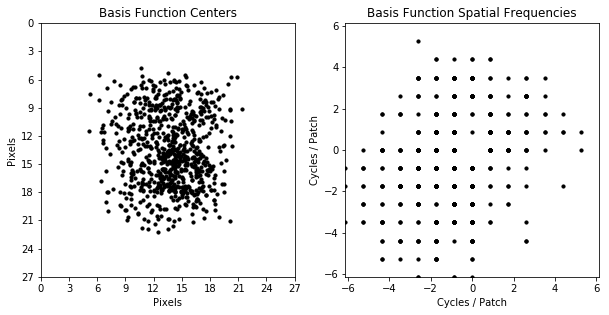

In [6]:
fig = pf.plot_loc_freq_summary(analyzer.bf_stats)
fig.savefig(analyzer.analysis_out_dir+"/vis/fig_location_frequency_centers.png")

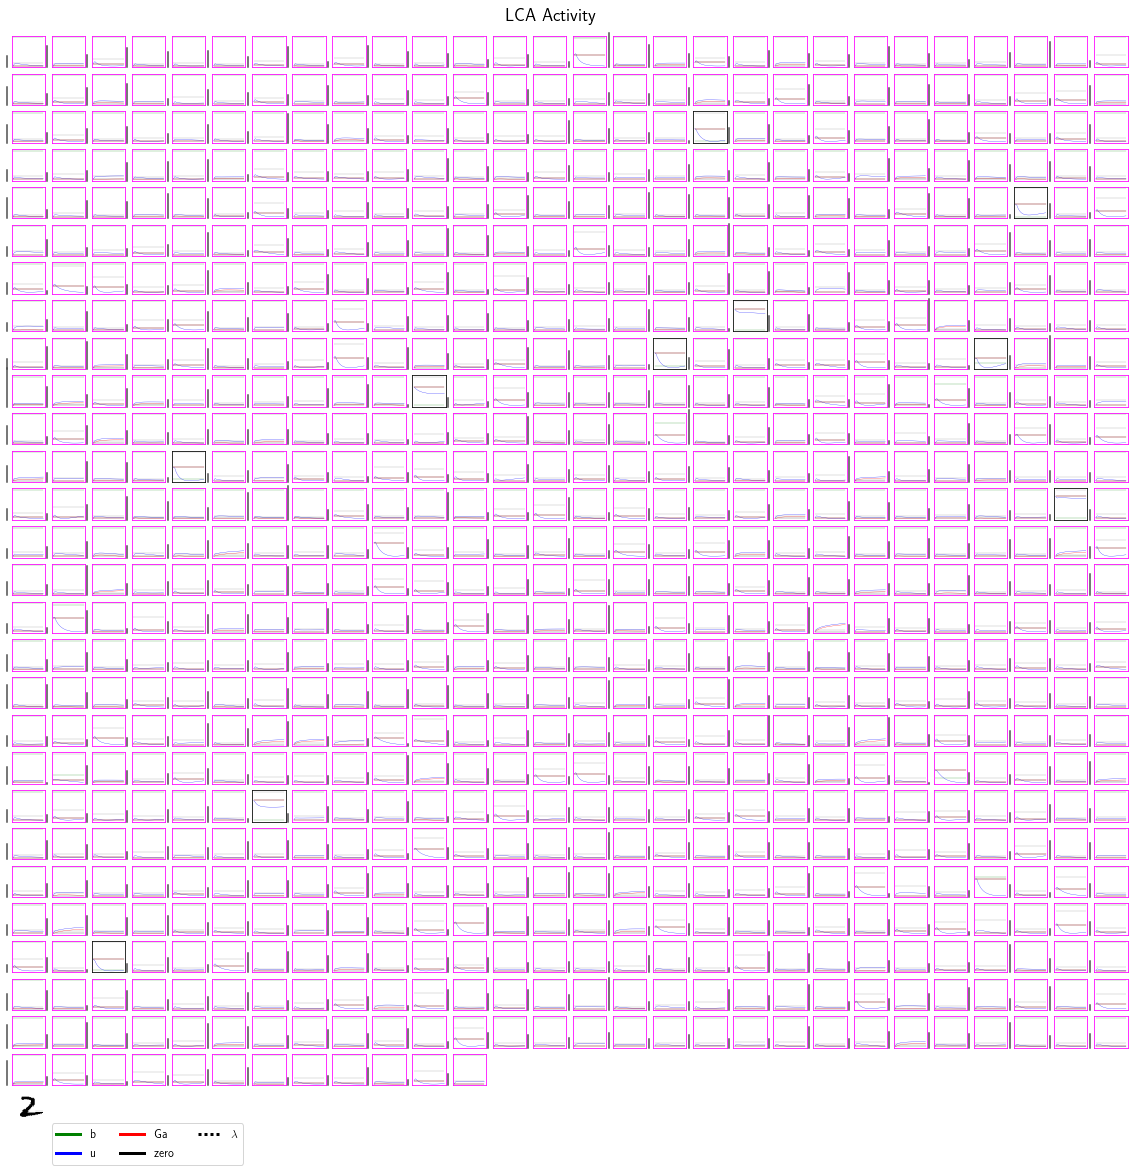

In [5]:
act_indicator_threshold = 0.80
inf_trace_fig = pf.plot_inference_traces(analyzer.inference_stats, analyzer.model_schedule[0]["sparse_mult"],
  act_indicator_threshold=act_indicator_threshold)
inf_trace_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params.model_name+"_inference_traces_dot_thresh-"+str(act_indicator_threshold)+"_"+analysis_params.save_info+".pdf")

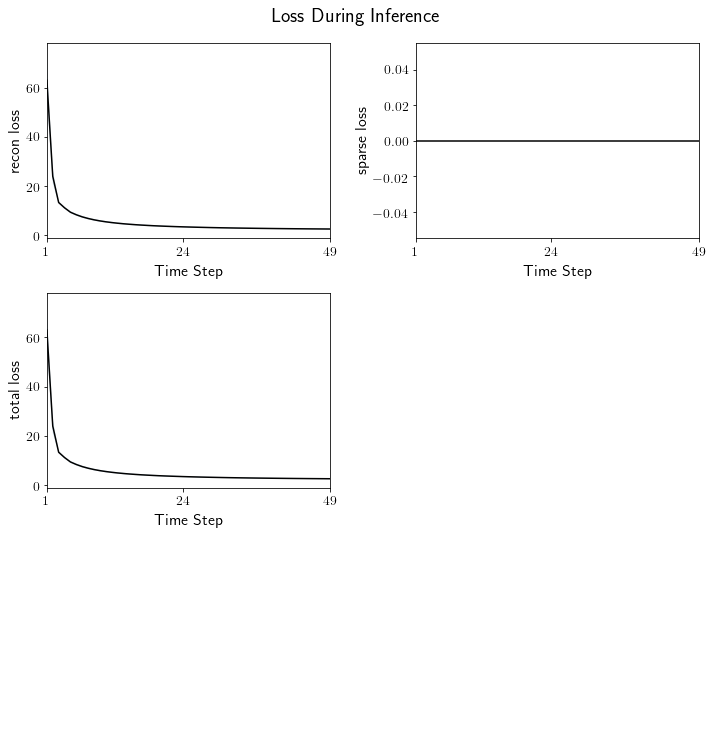

In [8]:
inf_stats_fig = pf.plot_inference_stats(analyzer.inference_stats, title="Loss During Inference")
inf_stats_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params.model_name+"_inference_loss_50_"+analysis_params.save_info+".png")

In [ ]:
#rectified_resp = analyzer.ot_grating_responses["rectified_responses"].reshape(2*analyzer.model_params.num_neurons,
#  len(ot_contrasts), len(ot_orientations))
#ot_fig = pf.plot_contrast_orientation_tuning(ot_bf_indices, ot_contrasts, ot_orientations, rectified_resp)
ot_fig = pf.plot_contrast_orientation_tuning(ot_bf_indices, ot_contrasts, ot_orientations, ot_mean_activations)
ot_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params.model_name+"_orientation_tuning.pdf")

In [ ]:
#cross_fig = pf.plot_masked_orientation_tuning(co_bf_indices, co_mask_orientations, co_base_mean_responses, analyzer.co_grating_responses["test_mean_responses"])
cross_fig = pf.plot_masked_orientation_tuning(co_bf_indices, co_mask_orientations, co_base_mean_responses, co_test_mean_responses)
cross_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params.model_name+"_cross_orientation_tuning.pdf")

In [ ]:
cross_contrast_fig = pf.plot_plaid_contrast_tuning(co_bf_indices, co_contrasts, co_contrasts, co_base_orientations,
  co_mask_orientations, co_test_mean_responses)
cross_contrast_fig.savefig(analyzer.analysis_out_dir+"/vis/"+analysis_params.model_name+"_cross_contrast_orientation_tuning.pdf")

In [ ]:
#grating = lambda bf_idx,orientation,phase,contrast:dp.generate_grating(
#  *dp.get_grating_params(bf_stats=analyzer.bf_stats, bf_idx=bf_idx, orientation=orientation,
#  phase=phase, contrast=contrast, diameter=-1)).reshape(16,16)
#
#bf_idx = 29
#bf = analyzer.evals["weights/phi:0"].T[co_bf_indices[bf_idx],:].reshape(16,16)
#base_stim = grating(co_bf_indices[bf_idx], co_base_orientations[bf_idx], co_phases[0], 0.5)
#mask_stim = grating(co_bf_indices[bf_idx], orthogonal_orientations[bf_idx], co_phases[5], 0.5)
#test_stim = base_stim + mask_stim
#
#all_min = np.min(np.stack([base_stim, mask_stim, test_stim]))
#all_max = np.max(np.stack([base_stim, mask_stim, test_stim]))
#
#fig, axes = plt.subplots(4)
#axes[0] = pf.clear_axis(axes[0])
#axes[1] = pf.clear_axis(axes[1])
#axes[2] = pf.clear_axis(axes[2])
#axes[3] = pf.clear_axis(axes[3])
#axes[0].imshow(bf, cmap="Greys_r")
#axes[1].imshow(base_stim, cmap="Greys_r", vmin=all_min, vmax=all_max)
#axes[2].imshow(mask_stim, cmap="Greys_r", vmin=all_min, vmax=all_max)
#axes[3].imshow(test_stim, cmap="Greys_r", vmin=all_min, vmax=all_max)
#plt.show()
#fig.savefig("/home/dpaiton/tmp_figs/"+analysis_params.model_name+"_ex_cross_stim.png")

In [ ]:
#constructed_bfs = np.zeros_like(analyzer.evals["weights/phi:0"].T)
#for bf_idx in range(constructed_bfs.shape[0]):
#  params = dp.get_grating_params(analyzer.bf_stats, bf_idx)
#  grating = dp.generate_grating(*params)
#  constructed_bfs[bf_idx,...] = grating.reshape(256)
#fig = pf.plot_data_tiled(constructed_bfs)

### compute iso_response_contrast curves

In [ ]:
outputs = analyzer.iso_response_contrasts(analyzer.bf_stats, base_contrast=0.5, contrast_resolution=0.01,
  closeness=0.01, num_alt_orientations=4, orientations=np.linspace(0.0, np.pi, 16),
  phases = np.linspace(-np.pi, np.pi, 12), neuron_indices=[52,53,54], diameter=-1,
  scale=analyzer.analysis_params.input_scale)

In [ ]:
outputs["iso_response_parameters"][0]